In [1]:
# load library
library(org.Mm.eg.db)
library(clusterProfiler)
library(dplyr)

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: IRanges

Loading required package: S4Vectors

In [2]:
# import data
data <- read.delim("E16.5_vs_untreated_E16.5.bed",sep="\t",header=T)
data2 <- read.delim("E16.5_vs_untreated_untreated.bed",sep="\t",header=T)
data3 <- read.delim("E16.5_vs_untreated_untreated.bed_E16.5.bed",sep="\t",header=T)

In [3]:
res <- rbind(data,data2,data3)

In [4]:
res$Parent.files <- gsub(".bed","",res$Parent.files)

In [5]:
res$gene <- case_when(
    is.na(res[,10]) ~ res[,9],
    is.na(res[,9]) ~ res[,10],
    .default = paste0(res[,9],",",res[,10])
         )

In [6]:
comparisons <- unique(res$Parent.files)

In [7]:
comparisons

[1] "E16.5"           "untreated"       "untreated|E16.5"

In [8]:
enrich_gene_list_for_test <- list()

In [9]:
# convert symbols to ENTREZID
for (key in comparisons){ 
    symbols <- res[which(res$Parent.files==key),]$gene
    symbols <- gsub("--[0-9]*",'',symbols)
    unique_symbols <- unique(unlist(strsplit(symbols, split = ","), recursive = FALSE))
    df <- bitr(unique_symbols, fromType = "SYMBOL",
        toType = c("ENSEMBL", "ENTREZID"),
        OrgDb = org.Mm.eg.db)
    enrich_gene_list_for_test[[ key ]] <- df$ENTREZID
    #enrich_gene_list_for_test[[ key ]] <- unique_symbols
}

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(unique_symbols, fromType = "SYMBOL", toType = c("ENSEMBL", :
“25.38% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(unique_symbols, fromType = "SYMBOL", toType = c("ENSEMBL", :
“6.58% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(unique_symbols, fromType = "SYMBOL", toType = c("ENSEMBL", :
“6.31% of input gene IDs are fail to map...”


### GO enrichment

In [10]:
enrich_GO <- compareCluster(geneCluster = enrich_gene_list_for_test, 
                                   ont           = "ALL",
                                   OrgDb = org.Mm.eg.db,
                                   keyType = 'ENTREZID',
                                   pAdjustMethod = "BH",
                                   pvalueCutoff  = 0.01,
                                   qvalueCutoff  = 0.05,
                                   fun =  enrichGO)

In [11]:
write.table(enrich_GO,"untreated_vs_E16.5_GO_enrichment.txt",sep="\t",quote=F)

png 
  2

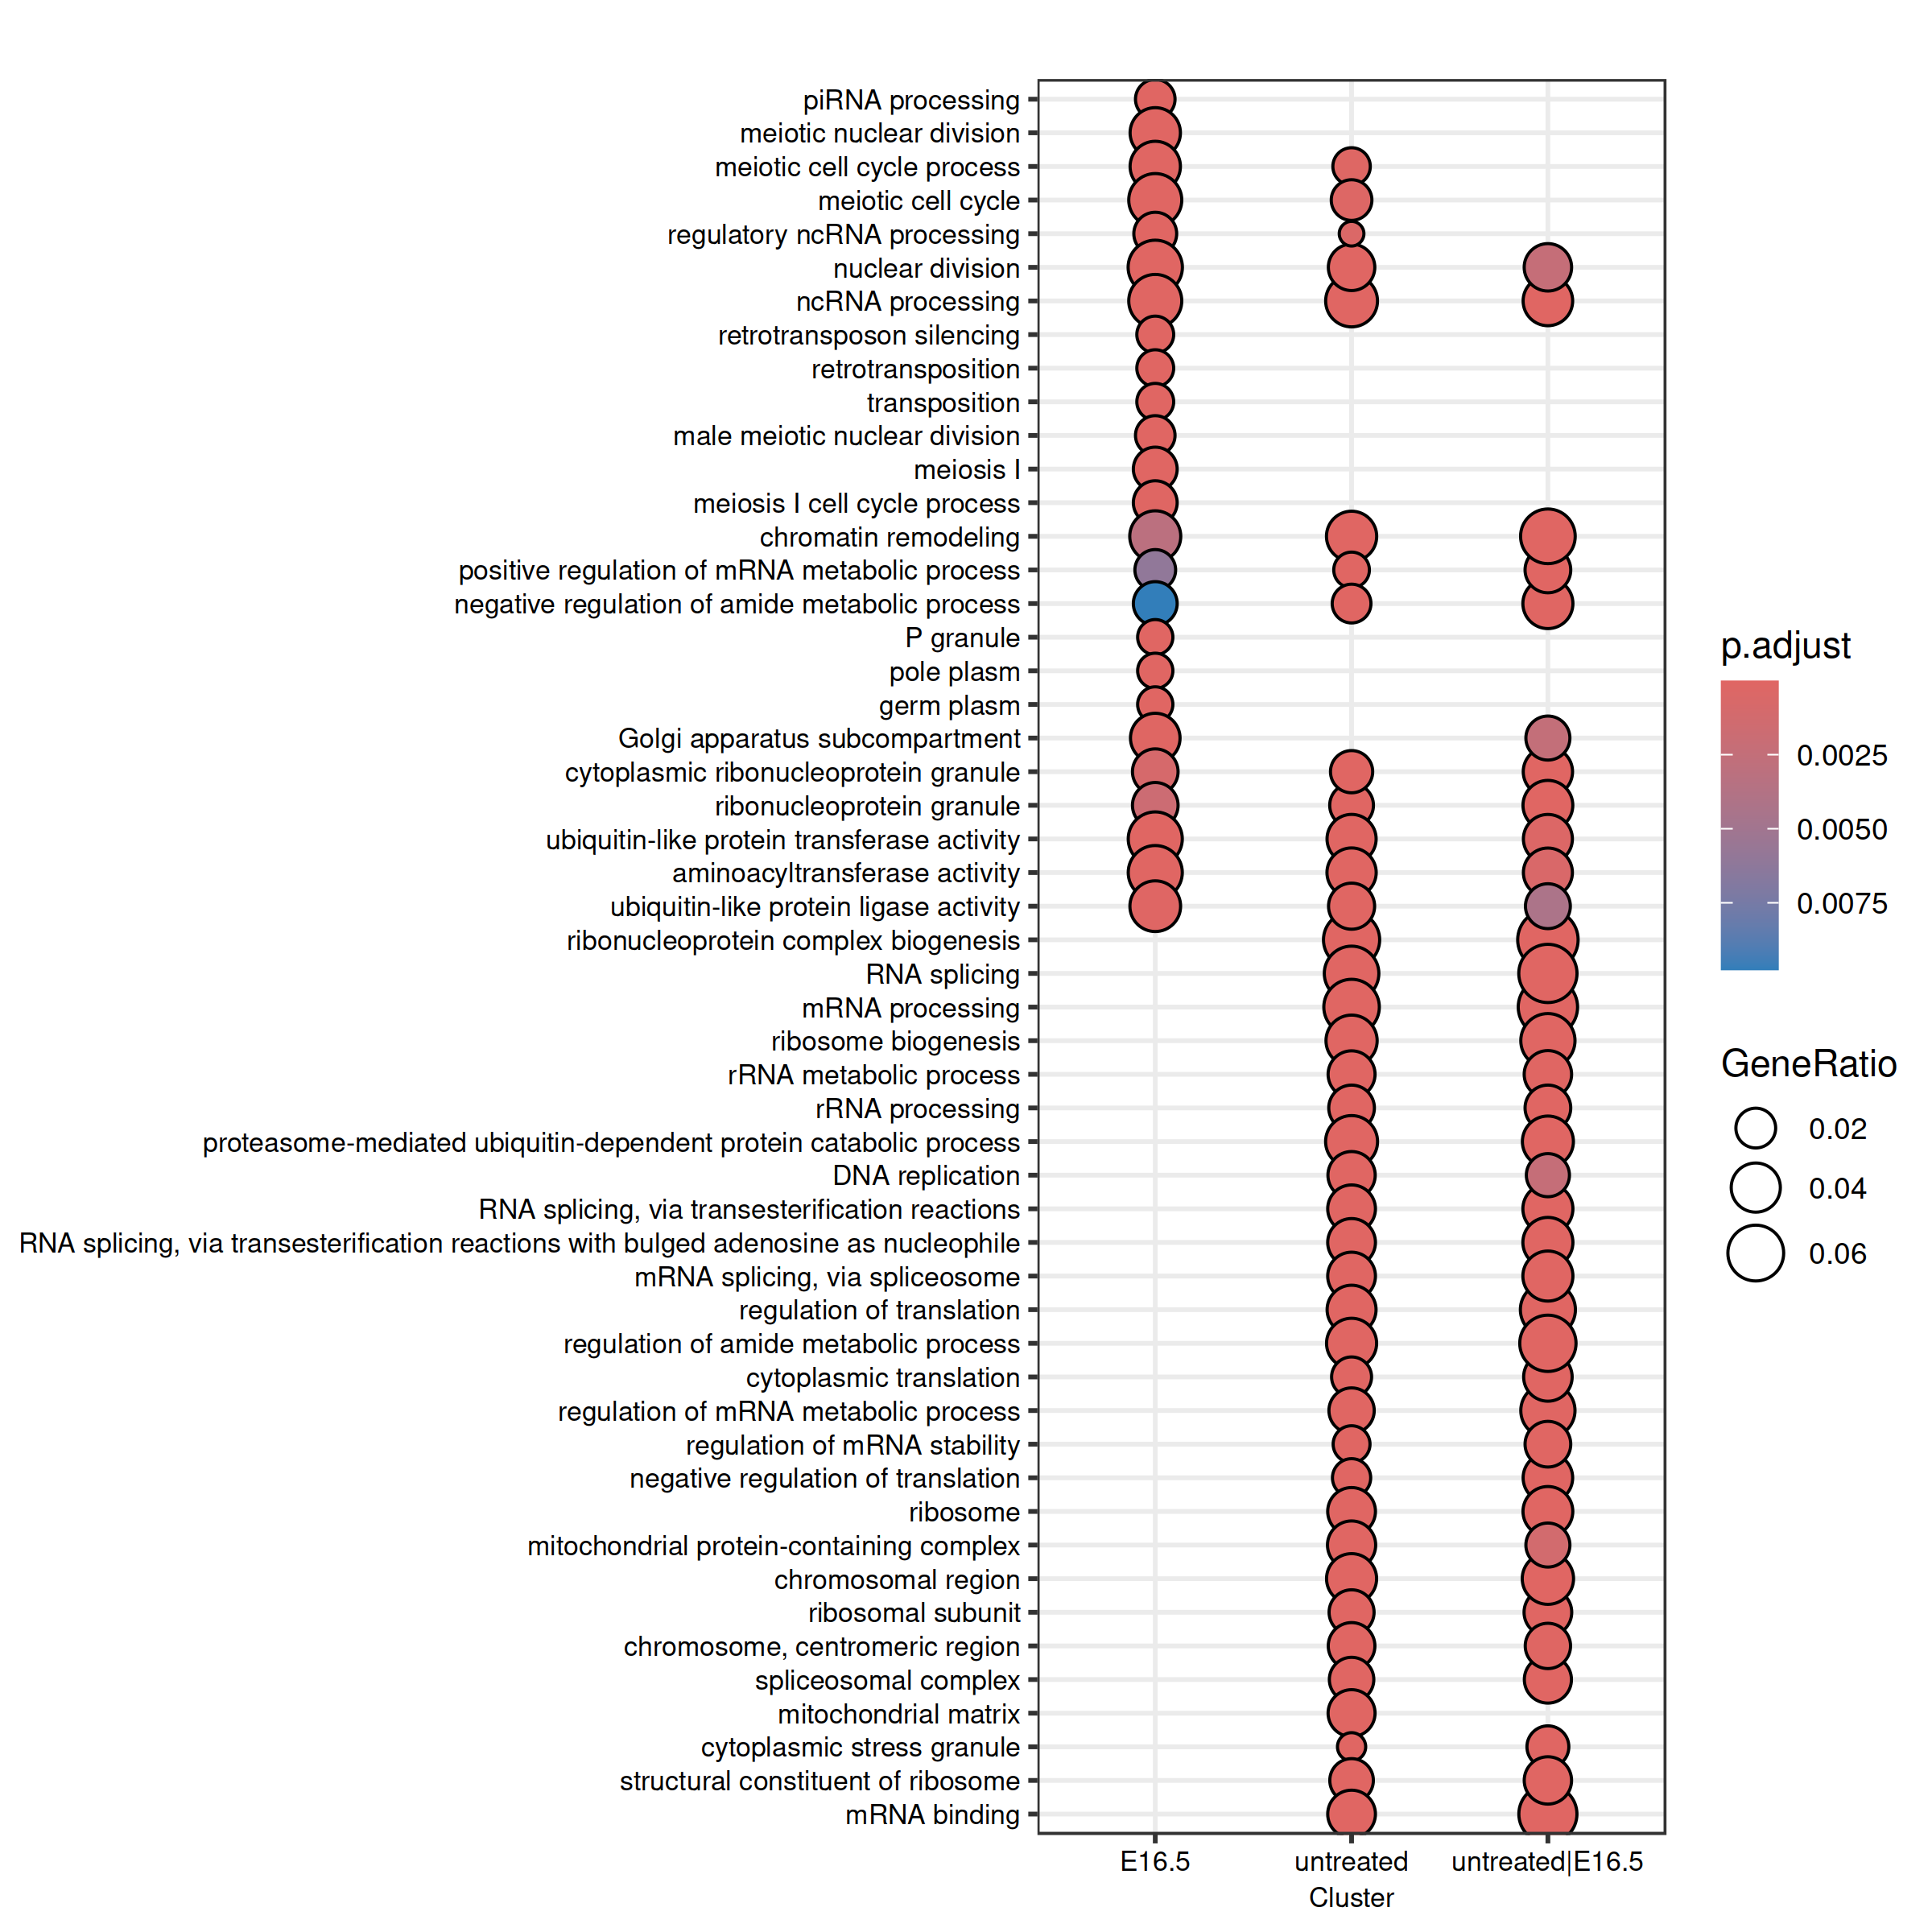

In [12]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)
p1 <- dotplot(enrich_GO,label_format = 100 ,showCategory=20, font.size=8)
pdf("untreated_vs_E16.5_GO_enrichment.pdf",height=8,width=8)
p1
dev.off()
p1

### KEGG enrichment

In [13]:
enrich_kegg <- compareCluster(geneCluster = enrich_gene_list_for_test, 
                                   organism = "mmu",
                                   pAdjustMethod = "BH",
                                   pvalueCutoff  = 0.01,
                                   qvalueCutoff  = 0.05,
                                   fun =  enrichKEGG)

In [14]:
write.table(enrich_kegg,"untreated_vs_E16.5_KEGG_enrichment.txt",sep="\t",quote=F)

png 
  2

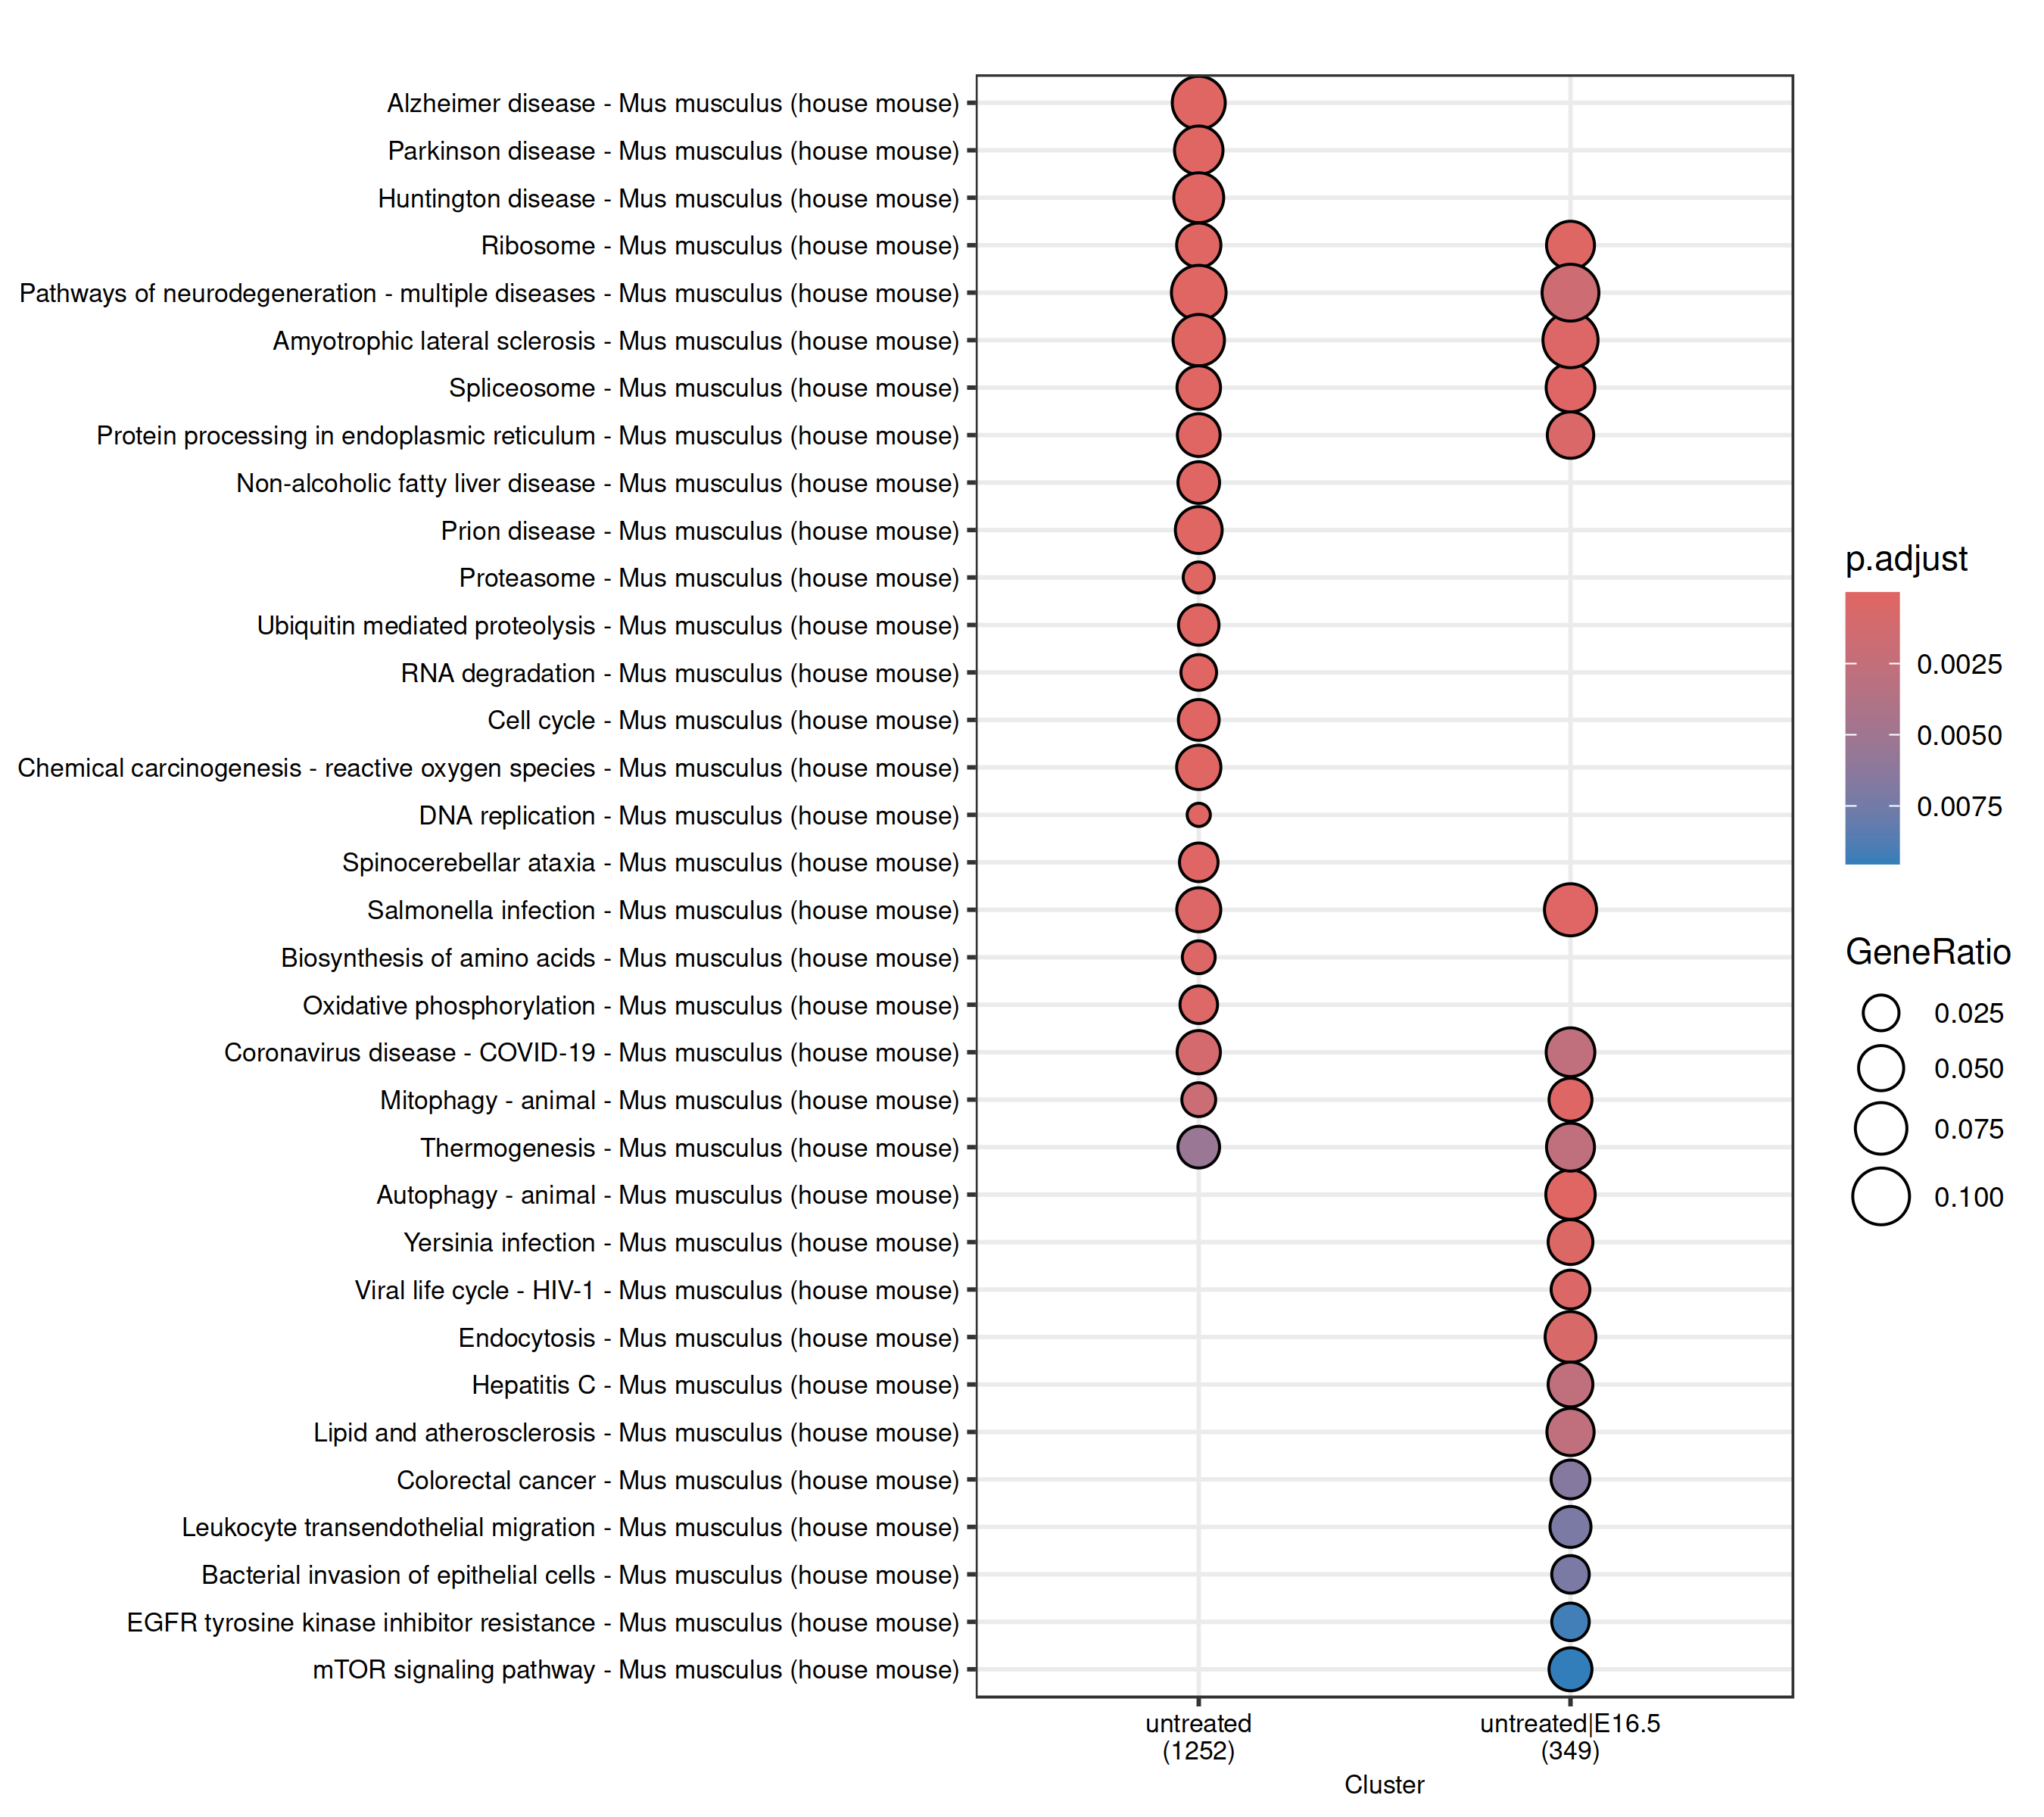

In [15]:
options(repr.plot.width = 9, repr.plot.height = 8, repr.plot.res = 300)
p2 <- dotplot(enrich_kegg,label_format = 100 ,showCategory=20, font.size=8)
pdf("untreated_vs_E16.5_KEGG_enrichment.pdf",height=8,width=9)
p2
dev.off()
p2